In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, PowerTransformer
import seaborn as sns

In [36]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  precision_list = []
  recall_list = []
  f1_score_list = []
  model.eval()

  with torch.no_grad():
    for x, y_true in loader:
      x = x.to(device = device)
      y = y_true.to(device = device)

      scores = model.forward(x.float())
      _, y_pred = scores.max(1)
      y_pred = y_pred.to(y_true.device)

      # tp = (y_true * y_pred).sum()
      # tn = ((1 - y_true) * (1 - y_pred)).sum()
      # fp = ((1 - y_true) * y_pred).sum()
      # fn = (y_true * (1 - y_pred)).sum()

      # epsilon = 1e-7
          
      precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
      precision_list.append(precision.tolist())
      recall = recall_score(y_pred, y_true, average='macro', zero_division=1)
      recall_list.append(recall.tolist())
      f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
      f1_score_list.append(f1.tolist())

      num_correct += (y_pred == y_true).sum()
      num_samples += y_pred.size(0)
  print(f'Got {num_correct} / {num_samples} with accuracy of {float(num_correct)/ float(num_samples)*100:.2f}')
  print(f'Average Precision Score: {np.mean(precision_list):.2f}')
  print(f'Average recall Score: {np.mean(recall_list):.2f}')
  print(f'Average f1-Score: {np.mean(f1_score_list):.2f}')
  return np.mean(f1_score_list)
  

In [37]:
def up_sampling(X_train, y_train):
  #Concatonate our our training data back together
  X = pd.concat([X_train, y_train], axis=1)
  #Seprate Minority and Majority Class
  opened_account = X[X['Personal Loan'] == 1]
  not_opened_account = X[X['Personal Loan'] == 0]
  #Upsample the Minority Class
  opened_account_upsampled = resample(opened_account,
                                      replace = True, #sample with replacement
                                      n_samples= len(not_opened_account), #match the number of not opened account
                                      random_state = 27)
  upsampled = pd.concat([opened_account_upsampled, not_opened_account])
  return upsampled

In [38]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer):
      super(NN, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_layer)
      self.fc2 = nn.Linear(hidden_layer, num_classes)
      self.sig = nn.Sigmoid()

    def forward(self, x):
      x = self.fc1(x)
      x = self.sig(x)
      x = self.fc2(x)
      return x

In [39]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [40]:
#Mount to drive and laod data
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#Go to Assignment directory
%cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [42]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name= 'Data')

X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = df['Personal Loan']
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

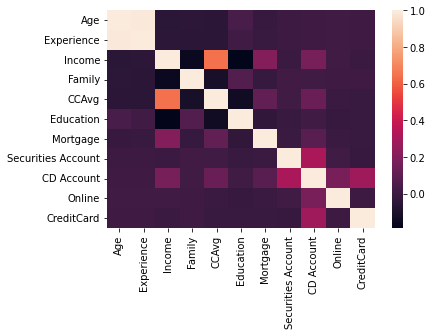

In [43]:
# Checking Corelation heatmap
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [44]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f4f0c890>,
      dtype=object)

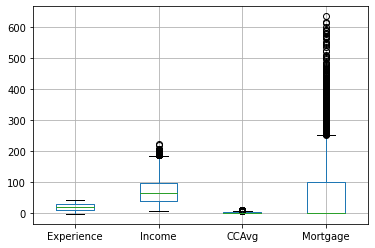

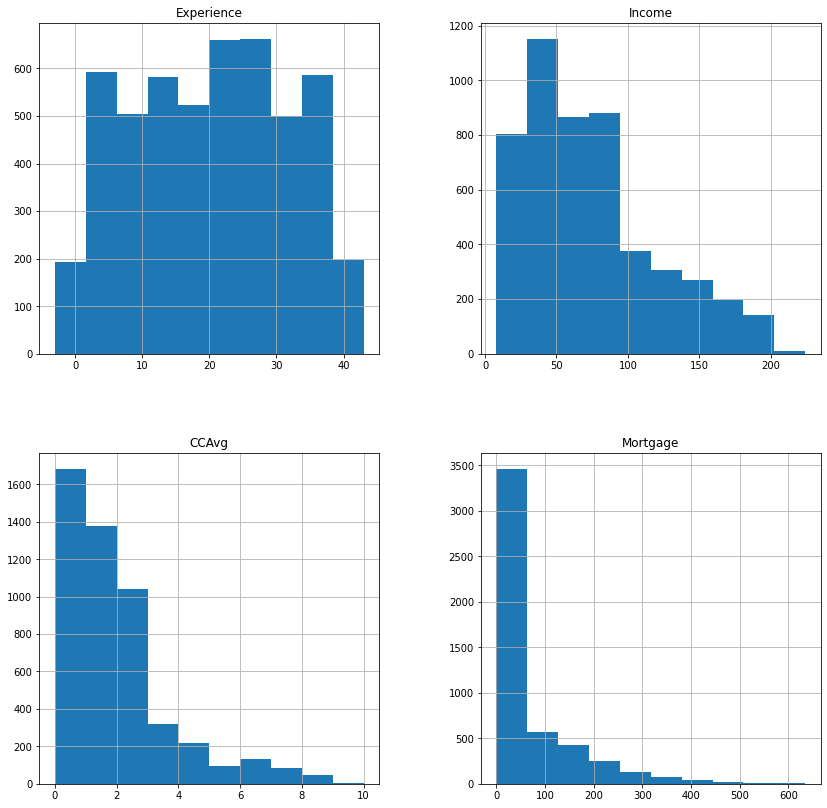

In [45]:
#EDA Analysis
continues_variables = X[['Experience', 'Income', 'CCAvg', 'Mortgage']]
continues_variables.boxplot() #See a large variation btw features need standardization.
continues_variables.hist(figsize=(14,14))

In [46]:
#Split the dataset to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27,stratify=y)

In [47]:
train = pd.concat([X_train, y_train], axis=1)

In [48]:
train_X = train.drop('Personal Loan', axis=1)
train_y = train['Personal Loan']

In [49]:
#Split Train Data set to Train and Validation set
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.15, stratify= train_y)

In [50]:
#Check Label Distribution Across splits
print(y.value_counts())
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0    4520
1     480
Name: Personal Loan, dtype: int64
0    2881
1     306
Name: Personal Loan, dtype: int64
0    509
1     54
Name: Personal Loan, dtype: int64
0    1130
1     120
Name: Personal Loan, dtype: int64


In [51]:
#Make Copy of X_train and X_val, X_test
X_train_stand = X_train.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

#Group Columns based on type
normal_col = ['Experience']
skewd_col = ['Income', 'CCAvg', 'Mortgage']
cat_col = ['Family', 'Education']

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, 
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col),
        ('Categorical_onhot', cat_pipeline, cat_col)],remainder ='passthrough')

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_val_stand = full_preprocessor.transform(X_val_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [53]:
df_X = pd.DataFrame(X_train_stand)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3f4d21950>,
      dtype=object)

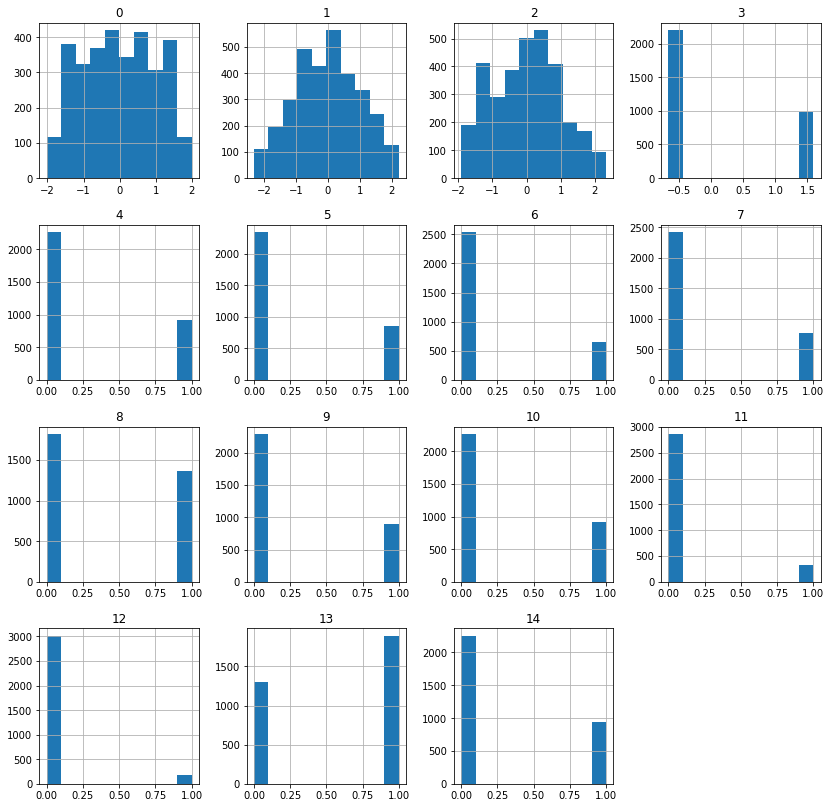

In [54]:
#Check Transformed Distribution
df_X.hist(figsize=(14,14))

In [56]:
#Converting Dataframe to Tensors
X_train_tensor = torch.tensor(X_train_stand)
X_val_tensor = torch.tensor(X_val_stand)
X_test_tensor = torch.tensor(X_test_stand)
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor = torch.tensor(y_val.values)
y_test_tensor = torch.tensor(y_test.values)

In [57]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor) 

In [149]:
#Hyperparameters
input_size = 15
num_classes = 2
hidden_layer = 10
learning_rate = 0.003
batch_size = 32
num_epochs = 10
regularization_rate = 0.0003
#

In [59]:
#Loading Train and Test dataset
train_data_load = DataLoader(dataset = train_data, batch_size = batch_size)
val_data_load = DataLoader(dataset = val_data, batch_size= batch_size)
test_data_load = DataLoader(dataset = test_data, batch_size = batch_size)

In [60]:
#Initialize Network
model = NN(input_size = input_size, num_classes = num_classes, hidden_layer= hidden_layer).to(device)

In [150]:
#Defining Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularization_rate)

In [151]:
epoch_c = []
val_score = []
train_score = []
epoch_loss = []
batch_loss = []
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_data_load):
    data = data.to(device=device)
    targets = targets.to(device=device)
    #Forward

    scores = model.forward(data.float())
    loss = criterion(scores, targets)
    batch_loss.append(loss.tolist())

    #backward
    optimizer.zero_grad()
    loss.backward()

    #Update Parameters
    optimizer.step()

    
    print(f'Batch # {batch_idx} Loss: {loss:.2f}')

  epoch_loss.append(np.mean(batch_loss))
  epoch_c.append(epoch)
  train_score.append(check_accuracy(train_data_load, model))
  val_score.append(check_accuracy(val_data_load, model))
  print(f'---> Epoch # {epoch} loss: {epoch_loss[epoch]:.2f}')
  print(f'-----> Validation score @ {epoch}: {val_score[epoch]:.2f}')


Batch # 0 Loss: 0.08
Batch # 1 Loss: 0.03
Batch # 2 Loss: 0.02
Batch # 3 Loss: 0.01
Batch # 4 Loss: 0.02
Batch # 5 Loss: 0.03
Batch # 6 Loss: 0.08
Batch # 7 Loss: 0.08
Batch # 8 Loss: 0.05
Batch # 9 Loss: 0.18
Batch # 10 Loss: 0.02
Batch # 11 Loss: 0.02
Batch # 12 Loss: 0.03
Batch # 13 Loss: 0.01
Batch # 14 Loss: 0.01
Batch # 15 Loss: 0.11
Batch # 16 Loss: 0.02
Batch # 17 Loss: 0.06
Batch # 18 Loss: 0.01
Batch # 19 Loss: 0.31
Batch # 20 Loss: 0.02
Batch # 21 Loss: 0.03
Batch # 22 Loss: 0.04
Batch # 23 Loss: 0.05
Batch # 24 Loss: 0.00
Batch # 25 Loss: 0.06
Batch # 26 Loss: 0.06
Batch # 27 Loss: 0.21
Batch # 28 Loss: 0.15
Batch # 29 Loss: 0.10
Batch # 30 Loss: 0.01
Batch # 31 Loss: 0.02
Batch # 32 Loss: 0.02
Batch # 33 Loss: 0.05
Batch # 34 Loss: 0.03
Batch # 35 Loss: 0.01
Batch # 36 Loss: 0.01
Batch # 37 Loss: 0.05
Batch # 38 Loss: 0.03
Batch # 39 Loss: 0.01
Batch # 40 Loss: 0.01
Batch # 41 Loss: 0.02
Batch # 42 Loss: 0.01
Batch # 43 Loss: 0.02
Batch # 44 Loss: 0.04
Batch # 45 Loss: 0.0

In [66]:
import matplotlib.pyplot as plt

def plot_learning_curve_mlp(epoch, train_score, val_score, x_label, y_label, title):
  plt.grid()
  plt.plot(epoch, train_score, 'r', label= 'Training Score')
  plt.plot(epoch, val_score, 'b', label = 'Validation Score')
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.title(title)
  plt.legend(loc='best')

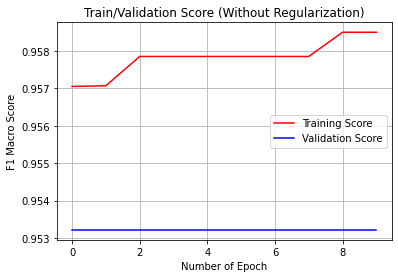

In [129]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Without Regularization)')

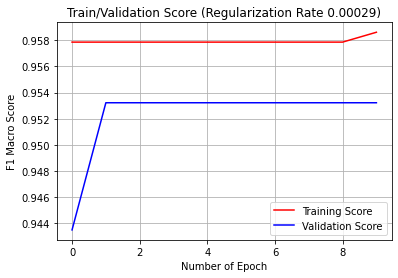

In [132]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Regularization Rate {})'.format(regularization_rate))

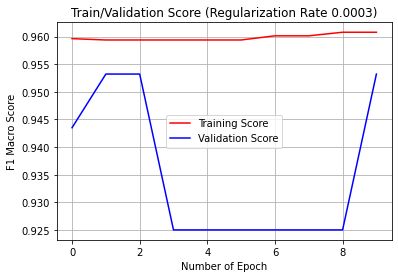

In [140]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Regularization Rate {})'.format(regularization_rate))

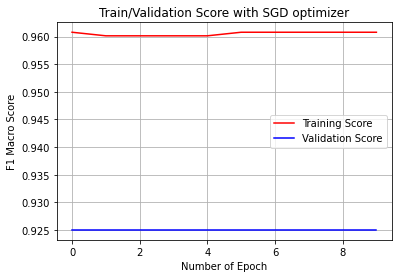

In [143]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score with SGD optimizer')

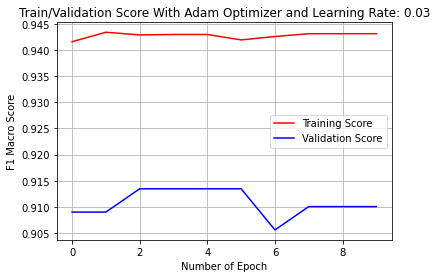

In [148]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score With Adam Optimizer and Learning Rate: {}'.format(learning_rate))

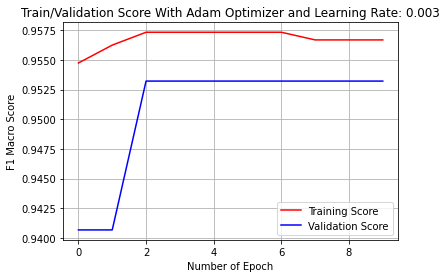

In [152]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score With Adam Optimizer and Learning Rate: {}'.format(learning_rate))

In [153]:
check_accuracy(test_data_load ,model)

Got 1224 / 1250 with accuracy of 97.92
Average Precision Score: 0.96
Average recall Score: 0.96
Average f1-Score: 0.95


0.9478431230338626